In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import tkinter as tk
from tkinter import filedialog

# Global variables
roi_coordinates = []
current_roi = None
drawing = False
selection_finished = False

# Mouse callback function for ROI selection
def select_roi(event, x, y, flags, param):
    global current_roi, roi_coordinates, drawing, selection_finished

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        current_roi = (x, y, 0, 0)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        roi_coordinates.append(current_roi)
        current_roi = None

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            current_roi = (current_roi[0], current_roi[1], x - current_roi[0], y - current_roi[1])

    elif event == cv2.EVENT_RBUTTONDOWN:
        selection_finished = True

# Keyboard callback function for finishing or canceling the selection
def finish_selection(event, x, y):
    global selection_finished

    if event == ord("f"):
        selection_finished = True
    elif event == ord("c"):
        selection_finished = False

# Function to calculate the signal change in an ROI
def calculate_signal_change(roi):
    # Convert the ROI to grayscale for simplicity
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Apply a blur to reduce noise
    blurred_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)

    # Calculate the mean pixel value in the ROI
    mean_pixel_value = np.mean(blurred_roi)

    return mean_pixel_value

# Function to track ROIs in a video
def track_roi_in_video(video_path, roi_coords, peak_threshold=4.0):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Read the first frame
    ret, frame = cap.read()
    if not ret:
        print("Error reading video")
        return

    # Create a window and set the mouse callback function
    cv2.namedWindow("Select ROIs")
    cv2.setMouseCallback("Select ROIs", select_roi)

    # Keep displaying the frame until the selection is finished
    while not selection_finished:
        # Clone the frame to draw rectangles on it
        display_frame = frame.copy()

        # Draw existing ROIs on the frame
        for roi in roi_coords:
            x, y, w, h = roi
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw the current ROI being selected (if any)
        if current_roi is not None:
            x, y, w, h = current_roi
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Display the frame
        cv2.imshow("Select ROIs", display_frame)

        # Wait for key press
        key = cv2.waitKey(1) & 0xFF

        # Exit if 'q' is pressed
        if key == ord("q"):
            break

    # Close the window
    cv2.destroyAllWindows()

    if not selection_finished:
        print("ROI selection canceled")
        return

    # Extract the ROIs from the first frame
    rois = [frame[y:y+h, x:x+w] for x, y, w, h in roi_coords]

    # Initialize variables for signal change tracking
    signal_changes = [[] for _ in range(len(rois))]
    previous_signals = [calculate_signal_change(roi) for roi in rois]

    # Loop through the video frames
    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            break

        # Extract the ROIs from the current frame
        current_rois = [frame[y:y+h, x:x+w] for x, y, w, h in roi_coords]

        # Calculate the signal change in each ROI
        current_signals = [calculate_signal_change(roi) for roi in current_rois]

        # Track the periodic behavior of the signals
        for i in range(len(rois)):
            # Calculate the change in signal
            signal_change = current_signals[i] - previous_signals[i]

            # Append the signal change to the list
            signal_changes[i].append(signal_change)

            # Update the previous signal value
            previous_signals[i] = current_signals[i]

    # Calculate the overall frequency
    overall_frequency = 1 / (len(signal_changes[0]) / cap.get(cv2.CAP_PROP_FPS))

    # Plot the signal changes for each ROI and display periodicity information
    for i in range(len(rois)):
        # Apply a threshold to the signal changes
        thresholded_signal_changes = np.array(signal_changes[i]) > peak_threshold

        # Find the peaks in the thresholded signal changes
        peaks, _ = find_peaks(thresholded_signal_changes)

        plt.subplot(len(rois), 1, i+1)
        plt.plot(signal_changes[i], label=f"ROI {i+1}")
        plt.plot(peaks, np.array(signal_changes[i])[peaks], "ro", label="Peaks")
        plt.xlabel("Frame")
        plt.ylabel("Signal Change")
        plt.legend()
        plt.title(f"Signal Change in ROI {i+1}\nNumber of Peaks: {len(peaks)}")

    plt.tight_layout()
    plt.show()

    # Save the signal changes to a file
    file_path = "signal_changes.txt"
    with open(file_path, "w") as file:
        file.write(f"Overall Frequency: {overall_frequency} Hz\n\n")
        for i in range(len(rois)):
            file.write(f"ROI {i+1}:\n")
            file.write(f"Number of Peaks: {len(peaks)}\n")  # Add number of peaks
            for j, signal_change in enumerate(signal_changes[i]):
                file.write(f"Frame {j+1}: {signal_change}\n")

    print(f"Signal changes saved to {file_path}")
    cap.release()

# Function to handle the video selection and start tracking
def select_video():
    video_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4")])
    if video_path:
        track_roi_in_video(video_path, roi_coordinates)

2023-06-06 16:37:28.230 python[66748:1156929] +[CATransaction synchronize] called within transaction
2023-06-06 16:37:28.303 python[66748:1156929] +[CATransaction synchronize] called within transaction


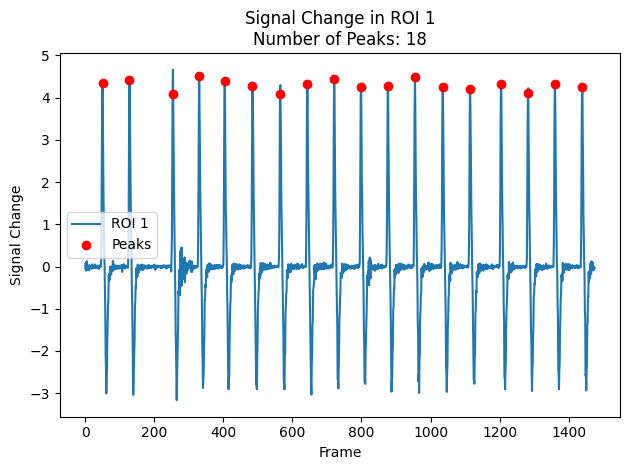

Signal changes saved to signal_changes.txt


In [3]:
# Create the main application window
window = tk.Tk()
window.title("Video ROI Tracker")

# Create a button to select the video file
select_button = tk.Button(window, text="Select Video", command=select_video)
select_button.pack(pady=10)

# Run the main event loop
window.mainloop()